## Improving the old MLP with good weight init

In [52]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
words = open("lines.txt", 'r').read().splitlines()
words = [wr.replace("/", "").replace("$", "") for wr in words]
words[:10]

["delicate savage  you'll never hold the cinder  but still you will burn ",
 'our destination  the skyline of this city  shining horizon ',
 'a splash and a cry   words pulled from the riverside   dried in the hot sun ',
 'hurt but poised for war  sturdy in crestfallen slumps  warrior spirit ',
 'steamy mist rising  rocks receiving downward crash  as the jungle weeps ',
 'a sultry wine night   spent with a beautiful girl   brash kiss ends smooth jazz ',
 'you were broken glass  but i touched you even though  i knew it would hurt ',
 'say not that i have  fled from the world but that the  world has fled from me ',
 'eyes dance with firelight  the moon and i are lovers  the spiteful sun dies ',
 'i woke up today  i wanted to write a song  i wrote a haiku ']

In [54]:
len(words)

11269

In [55]:
unwanted_chars = ['ß', 'à', 'ä', 'ç', 'è', 'é', 'ï', 'ñ', 'ó', 'ö', 'ü', 'ā']

def contains_unwanted_chars(word):
    return any(char in unwanted_chars for char in word)

filtered_haikus = [haiku for haiku in words if not any(contains_unwanted_chars(word) for word in haiku)]

In [56]:
words = filtered_haikus
len(words)

11235

In [57]:
chars = sorted(list(set(''.join(words))))
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

In [58]:
stoi

{' ': 0,
 "'": 1,
 ',': 2,
 '.': 3,
 'a': 4,
 'b': 5,
 'c': 6,
 'd': 7,
 'e': 8,
 'f': 9,
 'g': 10,
 'h': 11,
 'i': 12,
 'j': 13,
 'k': 14,
 'l': 15,
 'm': 16,
 'n': 17,
 'o': 18,
 'p': 19,
 'q': 20,
 'r': 21,
 's': 22,
 't': 23,
 'u': 24,
 'v': 25,
 'w': 26,
 'x': 27,
 'y': 28,
 'z': 29}

In [59]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [3] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(f"'{''.join(itos[i] for i in context)}'", '---->', itos[ix])

            context = context[1:] + [ix]
    
    X, Y = torch.tensor(X), torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random
random.seed(43)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([637487, 3]) torch.Size([637487])
torch.Size([79514, 3]) torch.Size([79514])
torch.Size([79753, 3]) torch.Size([79753])


In [60]:
g = torch.Generator().manual_seed(213139812739)
C = torch.randn(len(chars), 10, generator=g)

W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)

W2 = torch.randn((200, len(chars)), generator=g) * 0.01
b2 = torch.randn(len(chars), generator=g) * 0
params = [C, W1, b1, W2, b2]

In [61]:
for param in params:
    param.requires_grad = True

In [62]:
max_steps = 200000
batch_size = 128 

lossi = []

for i in range(max_steps):

    ix = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtrain[ix], Ytrain[ix]

    # forward pass
    emb = C[Xb]
    emb = emb.view(emb.shape[0], -1)

    out = torch.tanh(emb @ W1 + b1)
    out = out @ W2 + b2

    loss = F.cross_entropy(out, Yb)

    # backward pass
    for p in params:
        p.grad = None

    loss.backward()

    lr = 0.1 if i < 100000 else 0.01

    for p in params:
        p.data -= lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item()}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.4144859313964844
  10000/ 200000: 1.9098647832870483
  20000/ 200000: 1.803507685661316
  30000/ 200000: 1.9733134508132935
  40000/ 200000: 1.7005343437194824
  50000/ 200000: 2.022634744644165
  60000/ 200000: 1.8622506856918335
  70000/ 200000: 1.7281441688537598
  80000/ 200000: 1.6634043455123901
  90000/ 200000: 1.6902517080307007
 100000/ 200000: 1.6961257457733154
 110000/ 200000: 1.7178378105163574
 120000/ 200000: 1.6769464015960693
 130000/ 200000: 1.8368576765060425
 140000/ 200000: 1.8164705038070679
 150000/ 200000: 1.7573423385620117
 160000/ 200000: 1.5369887351989746
 170000/ 200000: 2.267834424972534
 180000/ 200000: 1.5109503269195557
 190000/ 200000: 1.8515267372131348


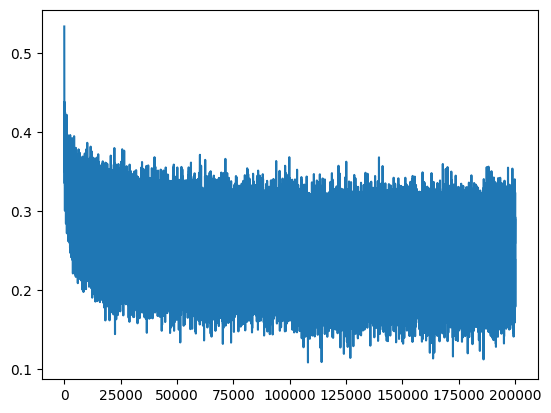

In [63]:
plt.plot(lossi)

In [64]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtrain, Ytrain),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[split]
    emb = C[x]
    emb = emb.view(emb.shape[0], -1)
    out = emb @ W1 + b1
    logits = F.tanh(out) @ W2 + b2
    loss = F.cross_entropy(logits, y)

    return loss.item()

split_loss('train'), split_loss('dev'), split_loss('test')

(1.7559022903442383, 1.7703694105148315, 1.785829782485962)

## Really good improvement

In [65]:
block_size = 3
for _ in range(20):
    out = []

    context = [3] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # print(ix)
        context = context[1:] + [ix]

        if ix == 3:
            break
        
        out.append(ix)

    print(''.join(itos[i] for i in out))
    print()

i can all ing   younderse are haveath recing 

hearth   soft the strance thermen spiat told mour lets  day 

hunthes one skiend my line bricher to love breats the would i haikuled words nour clow its hope 

me   i was  the vhing thoubblight   i wishird 

the red 

coconto paineckin to be 

along lets the enes  tear to dring and stilened 

whaterry i zanes   remarve freus an a bough  life leaveful rag infester corabeling the sad willust for more 

the nunselver casfriatls would i cle  he winted one  are of famn 

ancing of us deple  down   a blue  i new i was is asway   drop faile   like 

i fgence cast a pregreth in befucklack pubetrance  augh pine  pernet again thare 

poste  curly of brie 

i cer thirnely overgoreddirg and much in wintert nosetoday  tir stracicks have  fellent shing my am not tears shout a gux  i am nothat  my grows my whatrled on   coss ours ving fall upraying nicadistearly weath   moon 

six 

maning 

silence so hoice 

the suzsy path 

thiness  sure crofet a foe 